<a href="https://colab.research.google.com/github/FKz11/NN_PyTorch/blob/main/lesson_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lesson-8

### Библиотеки:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

## Обучить генератор создавать точки, которые будут лежать на графике функции $$y = \frac{sin(x)}{x} - \frac{x}{10}$$

### Dataset

In [2]:
class Data(Dataset):
    def __init__(self, func, min, max, num):
        self.num = num
        self.x = np.random.rand(num) * (max - min) + min
        self.func = func
        
    def __getitem__(self, index):
        point = self.x[index]
        return torch.FloatTensor([point, self.func(point)])
    
    def __len__(self):
        return self.num

### Function

In [3]:
FUNC = lambda x: np.sin(x)/x - x/10

In [4]:
MIN = -12
MAX = 12
NUM = 10000

In [5]:
data = Data(func=FUNC, min=MIN, max=MAX, num=NUM)
data[0]

tensor([0.5064, 0.9072])

### DataLoader

In [6]:
data_loader = DataLoader(data, batch_size=1000, shuffle=True)

### Discriminator

In [7]:
class Discriminator(nn.Module):
  def __init__(self, hidden_dim):
    super().__init__()

    self.linear_1 = nn.Linear(2, hidden_dim)
    self.linear_2 = nn.Linear(hidden_dim, hidden_dim // 2)
    self.linear_3 = nn.Linear(hidden_dim // 2, 1)

  def forward(self, x): 
    
    x = self.linear_1(x)
    x = torch.relu(x)
    x = self.linear_2(x)
    x = torch.relu(x)
    x = self.linear_3(x)
    x = torch.sigmoid(x)
    return x

### Generator

In [8]:
class Generator(nn.Module):
  def __init__(self, latent_dim, hidden_dim):
    super().__init__()

    self.linear_1 = nn.Linear(latent_dim, hidden_dim)
    self.linear_2 = nn.Linear(hidden_dim, 2)

  def forward(self, x): 
    
    x = self.linear_1(x)
    x = torch.tanh(x)
    x = self.linear_2(x)
    return x

### Инициализация

In [27]:
latent_dim = 1
hidden_dim = 64

discriminator = Discriminator(hidden_dim)
generator = Generator(latent_dim, hidden_dim)

# Для каждой нейронки свой опитимизатор
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=0.01, 
    betas=(0.5, 0.999)
)
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=0.01, 
    betas=(0.5, 0.999)
)

# Но вот функция ошибки у нас будет одна общая
loss = torch.nn.BCELoss()

### Обучение

Epoch: 10; Discriminator_loss: 0.69; Generator_loss: 0.716


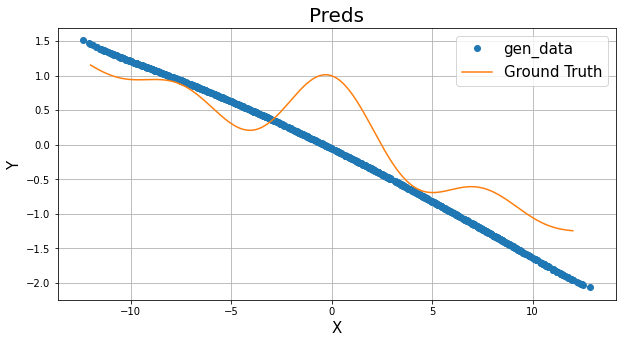

Epoch: 20; Discriminator_loss: 0.674; Generator_loss: 0.759


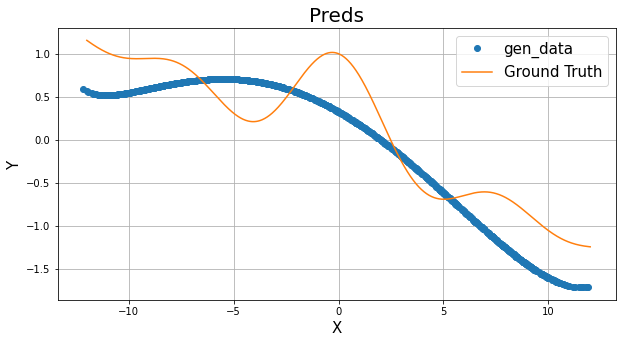

Epoch: 30; Discriminator_loss: 0.642; Generator_loss: 0.791


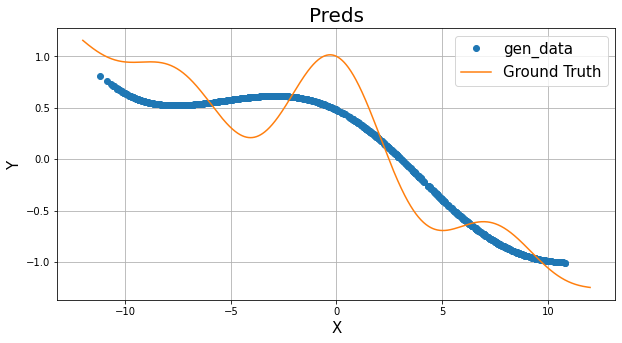

Epoch: 40; Discriminator_loss: 0.649; Generator_loss: 0.855


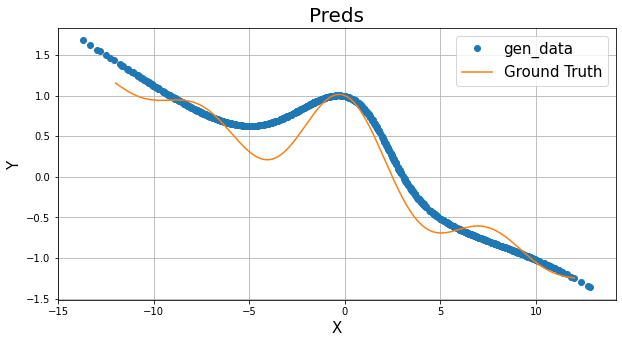

Epoch: 50; Discriminator_loss: 0.669; Generator_loss: 0.769


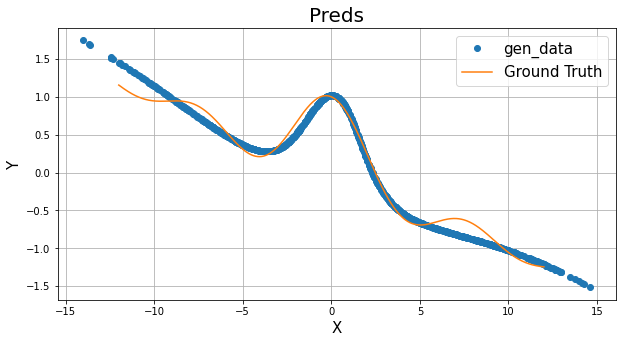

Epoch: 60; Discriminator_loss: 0.67; Generator_loss: 0.769


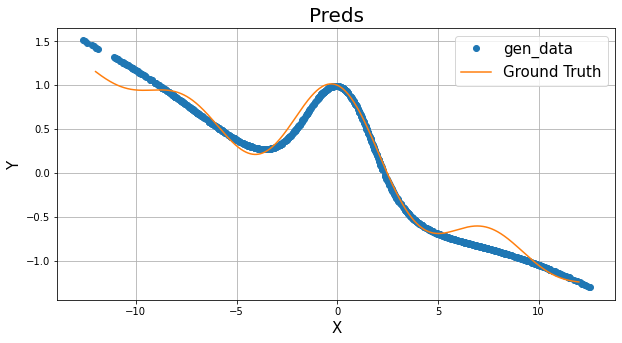

Epoch: 70; Discriminator_loss: 0.662; Generator_loss: 0.782


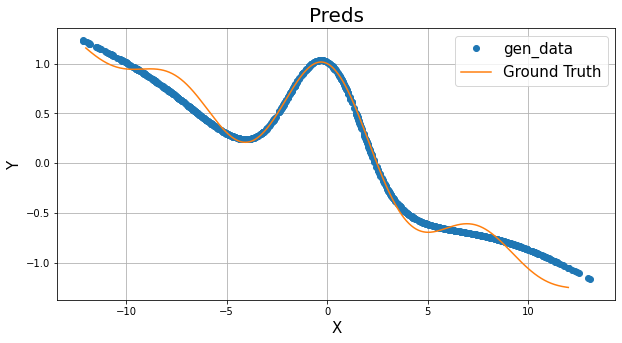

Epoch: 80; Discriminator_loss: 0.674; Generator_loss: 0.816


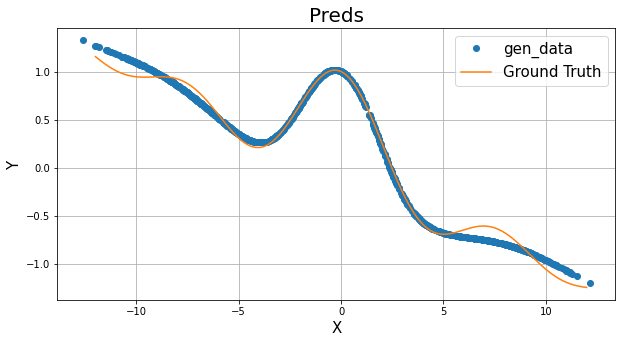

Epoch: 90; Discriminator_loss: 0.657; Generator_loss: 0.815


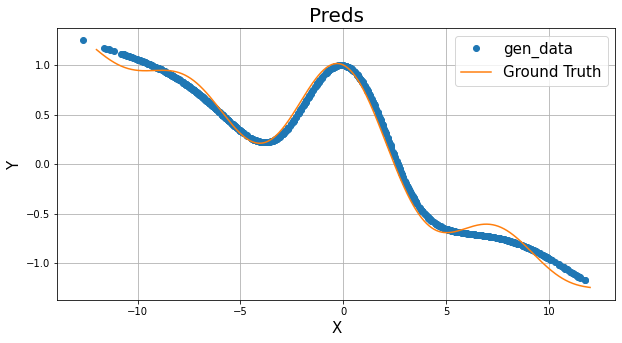

Epoch: 100; Discriminator_loss: 0.674; Generator_loss: 0.814


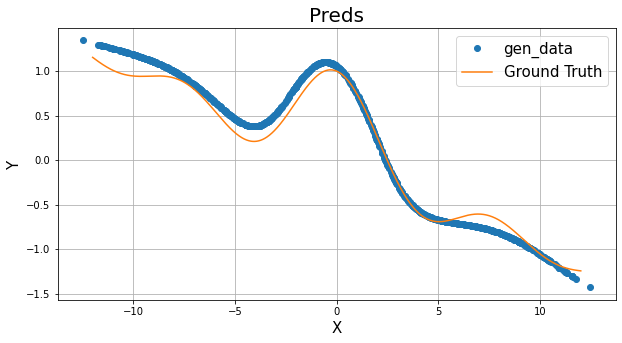

Epoch: 200; Discriminator_loss: 0.657; Generator_loss: 0.909


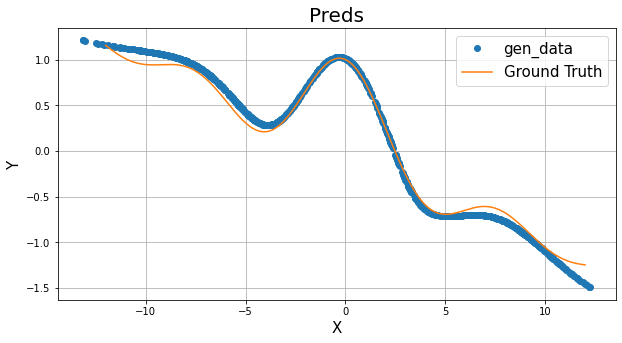

Epoch: 300; Discriminator_loss: 0.663; Generator_loss: 0.827


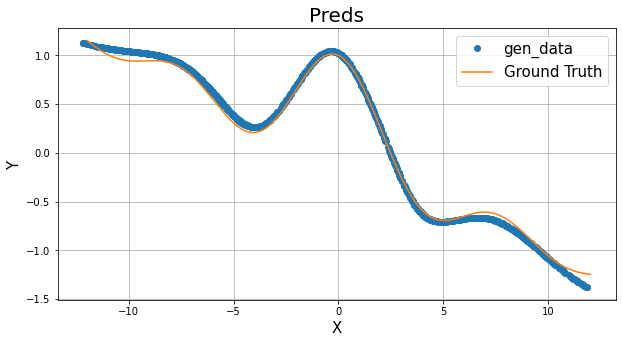

Epoch: 400; Discriminator_loss: 0.659; Generator_loss: 0.943


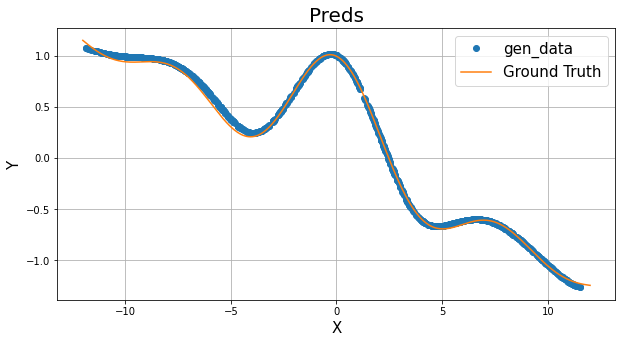

Epoch: 500; Discriminator_loss: 0.675; Generator_loss: 0.856


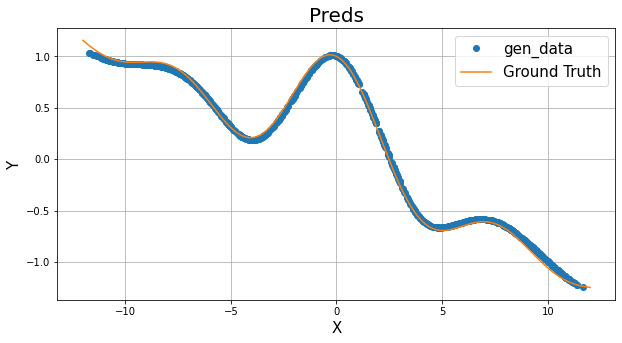

Epoch: 600; Discriminator_loss: 0.654; Generator_loss: 0.896


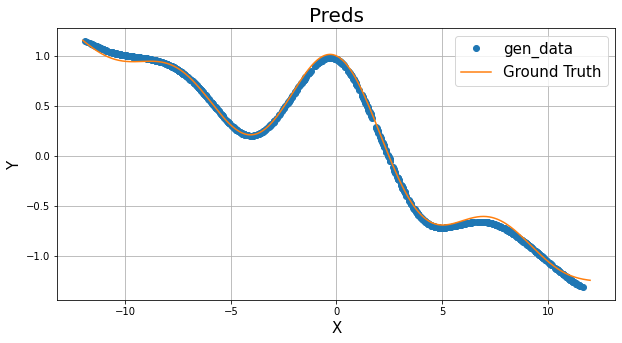

Epoch: 700; Discriminator_loss: 0.668; Generator_loss: 0.891


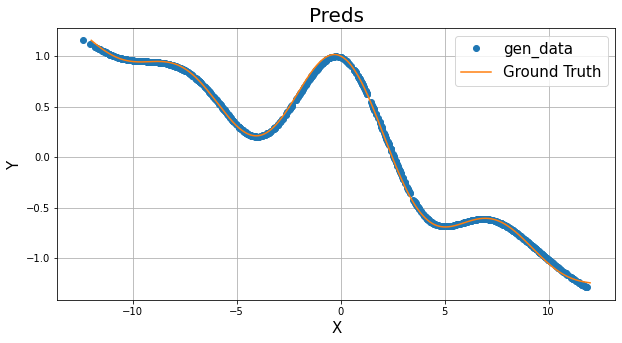

Epoch: 800; Discriminator_loss: 0.666; Generator_loss: 0.938


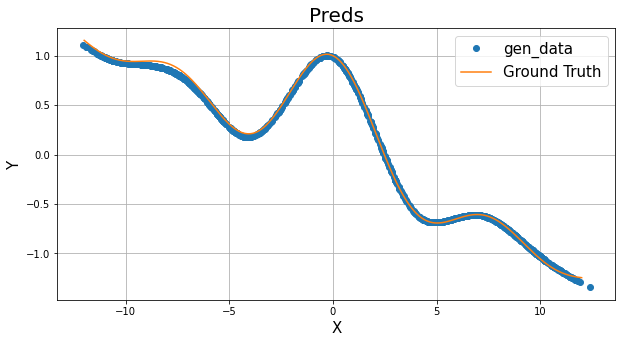

Epoch: 900; Discriminator_loss: 0.658; Generator_loss: 0.954


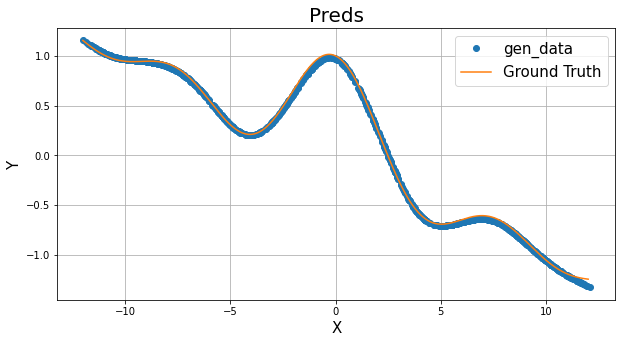

Epoch: 1000; Discriminator_loss: 0.642; Generator_loss: 1.019


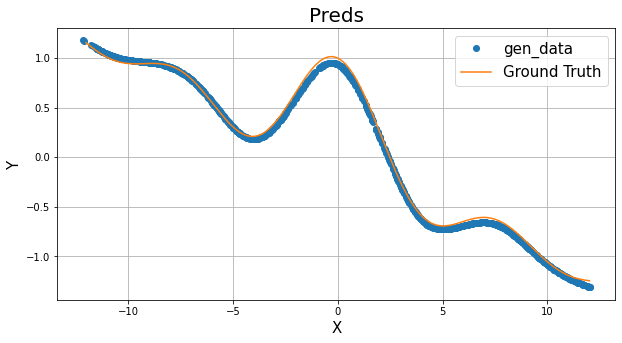

In [28]:
n_epochs = 1000

d_loss_history = []
g_loss_history = []

for epoch in range(n_epochs):

  d_loss_mean = 0.0
  g_loss_mean = 0.0

  for data in data_loader:

    batch_size = len(data)
                     
    real_labels = torch.FloatTensor(batch_size, 1).fill_(1.0)
    fake_labels = torch.FloatTensor(batch_size, 1).fill_(0.0)

    random_vectors = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))

    real_data = data
    gen_data = generator(random_vectors)

######################  Тренировка дискриминатора    ##########################

    real_pred = discriminator(real_data)
        
    d_real_loss = loss(real_pred, real_labels)
        
    fake_pred = discriminator(gen_data)
        
    d_fake_loss = loss(fake_pred, fake_labels)
        
    d_loss = (d_real_loss + d_fake_loss) / 2

    optimizer_D.zero_grad()
    d_loss.backward()
    optimizer_D.step()

######################  Тренировка генератора    ##########################

    random_vectors = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))
        
    gen_data = generator(random_vectors)

    fake_pred = discriminator(gen_data)
    
    g_loss = loss(fake_pred, real_labels)
        
    optimizer_G.zero_grad()
    g_loss.backward()
    optimizer_G.step()

    d_loss_mean += d_loss.item()
    g_loss_mean += g_loss.item()

  if ((epoch + 1) % 10 == 0 and (epoch + 1) < 100)  or ((epoch + 1) % 100) == 0:
    print(f'Epoch: {epoch + 1}; '\
            f'Discriminator_loss: {round(d_loss_mean / len(data_loader), 3)}; '\
            f'Generator_loss: {round(g_loss_mean / len(data_loader), 3)}')
  
    plt.figure(figsize = (10,5))
    plt.title('Preds', fontsize = 20)
    plt.grid(True)
    plt.ylabel('Y', fontsize = 15)
    plt.xlabel('X', fontsize = 15)

    gen_data = gen_data.detach().numpy()
    plt.plot(gen_data[:,0], gen_data[:,1], 'o', label='gen_data')

    plt.plot(np.linspace(MIN, MAX, 1000), FUNC(np.linspace(MIN, MAX, 1000)), label='Ground Truth')

    plt.legend(fontsize = 15)
    plt.show()
  
  d_loss_history.append(d_loss_mean / len(data_loader))
  g_loss_history.append(g_loss_mean / len(data_loader))

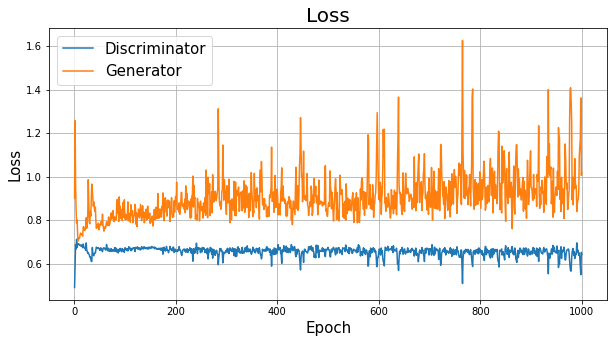

In [29]:
plt.figure(figsize = (10,5))

plt.title('Loss', fontsize = 20)
plt.grid(True)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.plot(range(1, n_epochs+1), d_loss_history, label='Discriminator')
plt.plot(range(1, n_epochs+1), g_loss_history, label='Generator')
plt.legend(fontsize = 15);

### Вывод

Я сгенерировал синтетические данные, как точки (x,y)

Я построил простейший Discriminator, 3 слойная линейная нейронная сеть с функциями активации relu и выходной функцией sigmoid, чтобы получить вероятностную оценку от 0 до 1 для точек.

Я построил Generator, 2 слойная линейная нейронная сеть с функцией активации tanh, так как эта функция хорошо описывает sin(x) который присутствует в Ground Truth, но tanh хуже чем relu передаёт градиент, поэтому в нейронной сети всего 2 слоя. На выходе не стоит функция активации, так как в теории точка (x,y) имеет область определения от -inf до +inf для каждой координаты.

Латентный вектор имеет размероность один, так как чтобы построить точки (x,y), где y=f(x), достаточно знать только x, а значит можно взять размерность один для латентного вектора z, ведь наш генератор может отобразить эту координату из латентного пространства на ось Х, а дальше найти y=f(x), только делая это параллельно, а не последовательно. Таким образом теоретически понятно, что для латентного вектора достаточно размерности один. Так же можно заметить, что при такой размерности латентного вектора распределение точек сразу принимает форму какой-то кривой, а не области, что уже является правильным, а значит брать большую размерность для латентного вектора неэффективно.

Как можно увидеть на графиках, на первых 100 эпохах идёт активное обучение генератора, дальше можно заметить, что генератору не удаётся построить только краевые точки. Это связано с тем, что при обучении генератора мы подаём ему на вход нормальное распределение, а значит генератор гораздо чаще строит точки в середине и гораздо реже краевые точки, соответственно реже на них ошибается и реже настраивает для них веса, зато он почти не ошибается для точек в центре.

В целом можно сказать, что у нас получилось научить генератор создавать точки из заданной функции. Но гораздо проще и лучше было бы интерпретировать эту задачу, как задачу регрессии, где x - data, y - label, loss - MSE. Но мы потренировались строить GAN на этой задаче.